In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [77]:
bob_ross.head()

,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


In [78]:
bob_ross.shape, bob_ross.columns[:15]

((403, 27),
 Index(['painting_index', 'img_src', 'painting_title', 'season', 'episode',
        'num_colors', 'youtube_src', 'colors', 'color_hex', 'Black_Gesso',
        'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna',
        'Indian_Red'],
       dtype='object'))

In [79]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

# Data Preprocessing for Unsupervised Analysis

1. Removal of non-analytical metadata

In [80]:

meta_cols = ['img_src', 'youtube_src', 'painting_title', 'color_hex']
bob_clean = bob_ross.drop(columns=meta_cols)


2. Filtering of extremely low-frequency colors

In [81]:
color_cols = bob_clean.select_dtypes(include='bool').columns
color_usage_rate = bob_clean[color_cols].mean()
selected_colors = color_usage_rate[color_usage_rate >= 0.1].index
X_colors = bob_clean[selected_colors].astype(int)


In [82]:
removed_colors = set(color_cols) - set(selected_colors)
print("Removed low-frequency colors:", removed_colors)


Removed low-frequency colors: {'Indian_Red', 'Liquid_Black'}


3. Handling mixed data types (binary + numeric)

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(bob_clean[['num_colors']])

X_final = np.hstack([X_colors.values, num_scaled])


# EDA （updated）

### 2.1 Are there clear differences in usage frequency across colors?

This EDA analyzes the frequency with which individual colors appear across paintings to distinguish core palette colors from more variable stylistic choices. By examining binary color usage indicators, we gain an initial understanding of the structural foundations of Bob Ross’s visual style.


/tmp/ipython-input-2344995409.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(jaccard_dist, method='average')


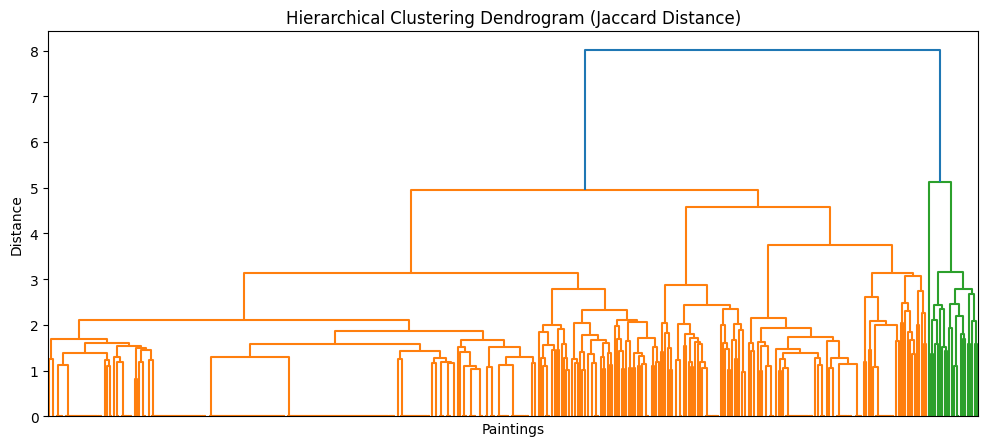

In [84]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


X_bool = X_colors.astype(bool).values

jaccard_dist = pairwise_distances(X_bool, metric='jaccard')

Z = linkage(jaccard_dist, method='average')


plt.figure(figsize=(12, 5))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (Jaccard Distance)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.show()


In [85]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
import numpy as np

k_values = range(2, 7)
sil_scores = []

for k in k_values:
    labels = fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(jaccard_dist, labels, metric='precomputed')
    sil_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")


K=2, Silhouette Score=0.5038
K=3, Silhouette Score=0.4973
K=4, Silhouette Score=0.3505
K=5, Silhouette Score=0.4062
K=6, Silhouette Score=0.3860


In [86]:
from scipy.cluster.hierarchy import fcluster


clusters_k3 = fcluster(Z, 3, criterion='maxclust')
bob_ross['cluster_k3'] = clusters_k3

print("Cluster sizes for K=3:")
print(bob_ross['cluster_k3'].value_counts().sort_index())

print("\nCluster proportions for K=3 (%):")
print((bob_ross['cluster_k3'].value_counts(normalize=True).sort_index() * 100).round(2))


Cluster sizes for K=3:
cluster_k3
1    381
2     21
3      1
Name: count, dtype: int64

Cluster proportions for K=3 (%):
cluster_k3
1    94.54
2     5.21
3     0.25
Name: proportion, dtype: float64


In [87]:

clusters_k5 = fcluster(Z, 5, criterion='maxclust')
bob_ross['cluster_k5'] = clusters_k5


print("Cluster sizes for K=5:")
print(bob_ross['cluster_k5'].value_counts().sort_index())


print("\nCluster proportions for K=5 (%):")
print((bob_ross['cluster_k5'].value_counts(normalize=True).sort_index() * 100).round(2))


Cluster sizes for K=5:
cluster_k5
1    265
2     38
3     78
4     21
5      1
Name: count, dtype: int64

Cluster proportions for K=5 (%):
cluster_k5
1    65.76
2     9.43
3    19.35
4     5.21
5     0.25
Name: proportion, dtype: float64


In [88]:

k = 5
clusters = fcluster(Z, k, criterion='maxclust')
bob_ross['cluster'] = clusters

print("Cluster counts:")
print(bob_ross['cluster'].value_counts())


cluster_profiles = X_colors.groupby(bob_ross['cluster']).mean()

for c in sorted(cluster_profiles.index):
    print(f"\nTop colors in Cluster {c}:")
    print(cluster_profiles.loc[c].sort_values(ascending=False).head(8))


Cluster counts:
cluster
1    265
3     78
2     38
4     21
5      1
Name: count, dtype: int64

Top colors in Cluster 1:
Titanium_White      1.000000
Midnight_Black      0.992453
Yellow_Ochre        0.981132
Alizarin_Crimson    0.981132
Cadmium_Yellow      0.973585
Van_Dyke_Brown      0.950943
Dark_Sienna         0.947170
Bright_Red          0.928302
Name: 1, dtype: float64

Top colors in Cluster 2:
Titanium_White      1.000000
Midnight_Black      0.973684
Van_Dyke_Brown      0.973684
Dark_Sienna         0.973684
Alizarin_Crimson    0.842105
Prussian_Blue       0.736842
Phthalo_Blue        0.710526
Bright_Red          0.289474
Name: 2, dtype: float64

Top colors in Cluster 3:
Titanium_White      0.987179
Alizarin_Crimson    0.974359
Cadmium_Yellow      0.961538
Van_Dyke_Brown      0.948718
Sap_Green           0.910256
Bright_Red          0.782051
Yellow_Ochre        0.743590
Burnt_Umber         0.679487
Name: 3, dtype: float64

Top colors in Cluster 4:
Titanium_White      0.952381
Prus

The clustering results show that most of Bob Ross’s paintings are built around a highly consistent core palette, with roughly two-thirds of works sharing a warm, earth-toned foundation. Stylistic variation emerges mainly through shifts in emphasis, such as increased use of greens, stronger incorporation of blues, or darker and more experimental base tones. This suggests that Ross’s style is not composed of entirely separate color systems, but rather a unified palette structure with several recognizable variations, along with a small number of clear outliers.

### 2.2 What are the main axes of variation in color usage? (PCA) And are there paintings that deviate strongly from the dominant palette patterns?

To understand how palette styles vary continuously across paintings, we applied Principal Component Analysis (PCA) to the color usage features. PCA reduces the high-dimensional color space into a smaller set of components that capture the most important directions of variation. Instead of forcing paintings into discrete groups, this method reveals the dominant ways in which color combinations change across the dataset.



In [89]:
X_color_vals = X_colors.values
num_scaled = StandardScaler().fit_transform(bob_clean[['num_colors']])
X_pca_input = np.hstack([X_color_vals, num_scaled])


PC1 explains 44.92% of variance
PC2 explains 13.32% of variance
PC3 explains 8.13% of variance
PC4 explains 6.61% of variance
PC5 explains 5.74% of variance


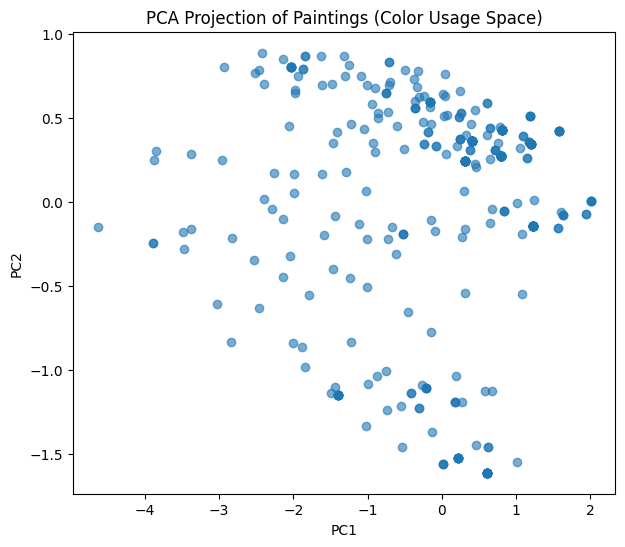

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_pca_input)


explained_var = pca.explained_variance_ratio_
for i, var in enumerate(explained_var, 1):
    print(f"PC{i} explains {var:.2%} of variance")

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Paintings (Color Usage Space)")
plt.show()


The PCA projection shows that most paintings form a dense central region in color usage space, indicating a highly consistent core palette. Variation occurs gradually along continuous axes rather than forming sharply separated groups. A few paintings appear far from the main cluster, suggesting rare or experimental palette configurations that deviate from Ross’s dominant color system.

In [91]:
feature_names = list(X_colors.columns) + ['num_colors']

loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)


print("Top contributors to PC1:")
print(loadings['PC1'].sort_values(ascending=False).head(8))
print(loadings['PC1'].sort_values().head(8))

print("\nTop contributors to PC2:")
print(loadings['PC2'].sort_values(ascending=False).head(8))
print(loadings['PC2'].sort_values().head(8))


Top contributors to PC1:
num_colors        0.812410
Indian_Yellow     0.255558
Yellow_Ochre      0.239270
Sap_Green         0.223385
Bright_Red        0.207328
Cadmium_Yellow    0.196300
Dark_Sienna       0.162427
Phthalo_Blue      0.147782
Name: PC1, dtype: float64
Burnt_Umber        -0.009185
Titanium_White      0.013516
Liquid_Clear        0.036746
Prussian_Blue       0.048523
Black_Gesso         0.058650
Alizarin_Crimson    0.075705
Phthalo_Green       0.083547
Van_Dyke_Brown      0.083817
Name: PC1, dtype: float64

Top contributors to PC2:
Dark_Sienna       0.546589
Midnight_Black    0.524192
Liquid_Clear      0.094258
Black_Gesso       0.078455
Phthalo_Blue      0.044063
Van_Dyke_Brown    0.028465
Titanium_White    0.005741
Yellow_Ochre     -0.008573
Name: PC2, dtype: float64
Burnt_Umber      -0.408300
Phthalo_Green    -0.407198
Sap_Green        -0.219225
Cadmium_Yellow   -0.106833
Bright_Red       -0.087561
Prussian_Blue    -0.075728
Indian_Yellow    -0.042572
num_colors       -

In [92]:
from scipy.spatial.distance import cdist


X_2d = X_pca[:, :2]
center = X_2d.mean(axis=0)
distances = cdist(X_2d, [center]).flatten()


bob_clean['pca_distance'] = distances
outliers = bob_clean.sort_values('pca_distance', ascending=False).head(5)

outliers[['painting_index', 'season', 'episode', 'pca_distance']]

outliers = outliers.merge(
    bob_ross[['painting_index', 'painting_title']],
    on='painting_index',
    how='left'
)

outliers[['painting_title', 'season', 'episode', 'pca_distance']]



,painting_title,season,episode,pca_distance
0,Contemplative Lady,16,6,4.638402
1,Winter Mist,1,4,3.897631
2,Shades of Grey,2,4,3.897631
3,Blue Winter,21,10,3.878748
4,Grey Winter,7,11,3.855388
